In [1]:
#=====================Importing Necessary Libraries==========================#

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, SpatialDropout1D
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [2]:
#====================Reading Preprocessed Data========================#

df = pd.read_csv('preprocessed_data.csv')

df['clean_tweet'] = df['clean_tweet'].astype(str)

# Convert preprocessed tweets and labels to numpy arrays
tweets = df['clean_tweet'].values
labels = df['label'].values

In [3]:
#=====================Text Tokenization and Sequence Padding======================#

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(tweets)

# Pad sequences to ensure uniform length
max_length = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_length)

In [4]:
#====================Dataset Split (Training:Testing)=======================#

# Convert labels to categorical
y = np.array(labels)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
#====================LSTM Model Build========================#

# Build LSTM model
embedding_dim = 100
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [6]:
#=====================LSTM Model Training=========================#

# Apply early stopping to avoid overfitting of data
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Train model
batch_size = 64
epochs = 10
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/10
310/310 [==============================] - 54s 157ms/step - loss: 0.2114 - accuracy: 0.9149 - val_loss: 0.1344 - val_accuracy: 0.9484
Epoch 2/10
310/310 [==============================] - 32s 103ms/step - loss: 0.0850 - accuracy: 0.9687 - val_loss: 0.1397 - val_accuracy: 0.9455
Epoch 3/10
310/310 [==============================] - 31s 101ms/step - loss: 0.0521 - accuracy: 0.9815 - val_loss: 0.1745 - val_accuracy: 0.9403
Epoch 4/10
310/310 [==============================] - 38s 122ms/step - loss: 0.0351 - accuracy: 0.9871 - val_loss: 0.2182 - val_accuracy: 0.9356
Epoch 4: early stopping


In [7]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

#============================ Model Evaluation============================#

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions on the test data
y_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate classification report
target_names = ['Appropriate', 'Inappropriate']
report = classification_report(y_test, y_pred, target_names=target_names)

# Print the classification report
print("Classification Report:\n", report)

# Calculate additional evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print("\nEvaluation Metrics:\n")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


155/155 [==============================] - 2s 11ms/step - loss: 0.2182 - accuracy: 0.9356
Test Loss: 0.2181752771139145
Test Accuracy: 0.9356465339660645
155/155 [==============================] - 2s 9ms/step
Classification Report:
                precision    recall  f1-score   support

  Appropriate       0.83      0.78      0.80       835
Inappropriate       0.96      0.97      0.96      4122

     accuracy                           0.94      4957
    macro avg       0.89      0.87      0.88      4957
 weighted avg       0.93      0.94      0.93      4957


Evaluation Metrics:

Accuracy: 0.9356465604196086
Precision: 0.9556673855739276
Recall: 0.9674915089762252
F1-score: 0.9615430982519589


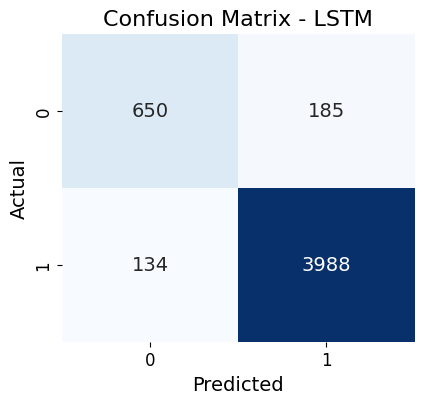

In [8]:
#============================ Confusion Matrix ============================#

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Confusion Matrix - LSTM', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import tensorflow as tf
import torch
from torch.utils.data import DataLoader, Dataset

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import download
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

#============================ Text Preprocessing ============================#

stop_words = set(stopwords.words('english'))
stop_words.add("rt") # adding rt to remove retweet in dataset

# Removing Emojis
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# Replacing user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)
    return text

# Removing URLs
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)
    return text

# Removing Unnecessary Symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')
    text = text.replace(".", '')
    text = text.replace(",", '')
    text = text.replace("#", '')
    text = text.replace(":", '')
    text = text.replace("@", '')
    text = text.replace("?", '')
    return text


# Removing stopwords
def remove_stopwords(raw_text):
    tokenize = word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = ' '.join(text)
    return text

# Stemming
def stemming(raw_text):
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in raw_text.split()]
    return ' '.join(words)

def preprocess(data):
    clean = []
    clean = [text.lower() for text in data]
    clean = [change_user(text) for text in clean]
    clean = [remove_entity(text) for text in clean]
    clean = [remove_url(text) for text in clean]
    clean = [remove_noise_symbols(text) for text in clean]
    clean = [stemming(text) for text in clean]
    clean = [remove_stopwords(text) for text in clean]

    return clean


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
#============================ Model preformance Testing ============================#

# Preprocess custom text
custom_text = ["Kill Yourself"]
preprocessed_custom_text = preprocess(custom_text)[0]

# Tokenize and pad the sequence
custom_sequence = tokenizer.texts_to_sequences([preprocessed_custom_text])
padded_custom_sequence = pad_sequences(custom_sequence, maxlen=max_length)

# Make prediction
prediction = model.predict(padded_custom_sequence)
print(prediction)

# Interpret the prediction result
if prediction > 0.5:
    print("Inappropriate.")
else:
    print("Appropriate.")


1/1 [==============================] - 0s 84ms/step
[[0.66976553]]
Inappropriate.
